**Baseline CNN Model with and without Data Augmentation**

Epoch 1/15, Train Loss: 1.6921, Train Acc: 0.3692, Val Loss: 1.3735, Val Acc: 0.4910
Epoch 2/15, Train Loss: 1.3029, Train Acc: 0.5306, Val Loss: 1.1334, Val Acc: 0.5944
Epoch 3/15, Train Loss: 1.1171, Train Acc: 0.6053, Val Loss: 0.9865, Val Acc: 0.6528
Epoch 4/15, Train Loss: 0.9914, Train Acc: 0.6570, Val Loss: 0.9418, Val Acc: 0.6746
Epoch 5/15, Train Loss: 0.8950, Train Acc: 0.6966, Val Loss: 0.8652, Val Acc: 0.6962
Epoch 6/15, Train Loss: 0.8145, Train Acc: 0.7207, Val Loss: 0.8407, Val Acc: 0.7130
Epoch 7/15, Train Loss: 0.7621, Train Acc: 0.7400, Val Loss: 0.8239, Val Acc: 0.7204
Epoch 8/15, Train Loss: 0.6972, Train Acc: 0.7605, Val Loss: 0.7939, Val Acc: 0.7284
Epoch 9/15, Train Loss: 0.6601, Train Acc: 0.7756, Val Loss: 0.8187, Val Acc: 0.7348
Epoch 10/15, Train Loss: 0.6187, Train Acc: 0.7883, Val Loss: 0.7903, Val Acc: 0.7434
Epoch 11/15, Train Loss: 0.5772, Train Acc: 0.8031, Val Loss: 0.7823, Val Acc: 0.7446
Epoch 12/15, Train Loss: 0.5493, Train Acc: 0.8123, Val Loss: 0

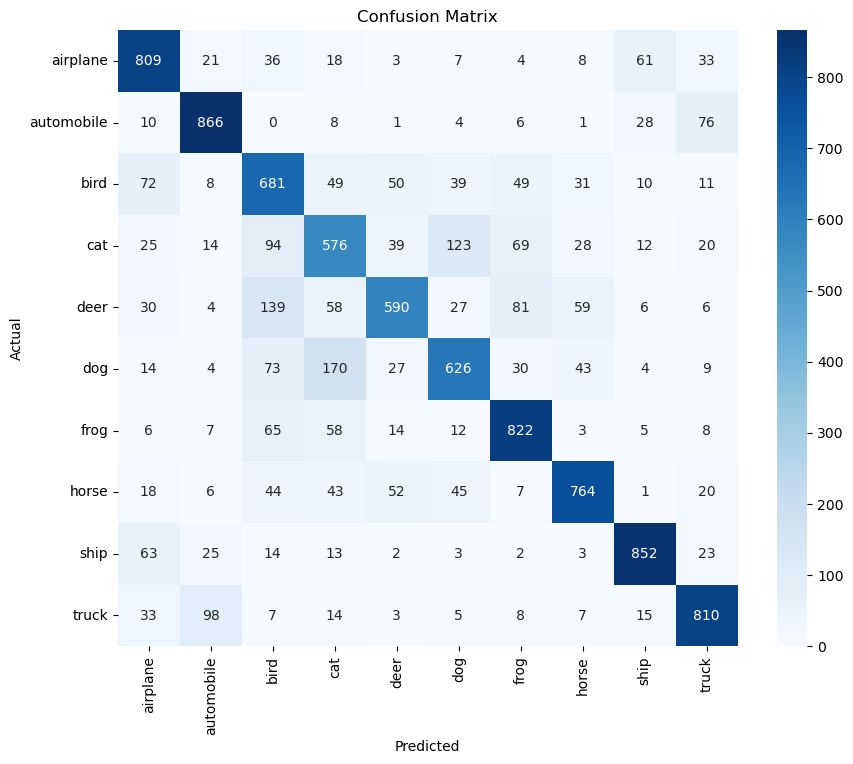


Results with Data Augmentation:
Accuracy: 0.7462, F1 Score: 0.7396, Precision: 0.7454, Recall: 0.7462
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.87      0.77      1000
           1       0.87      0.92      0.90      1000
           2       0.70      0.52      0.60      1000
           3       0.64      0.41      0.50      1000
           4       0.73      0.71      0.72      1000
           5       0.62      0.71      0.66      1000
           6       0.73      0.84      0.78      1000
           7       0.75      0.81      0.78      1000
           8       0.90      0.80      0.85      1000
           9       0.83      0.87      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



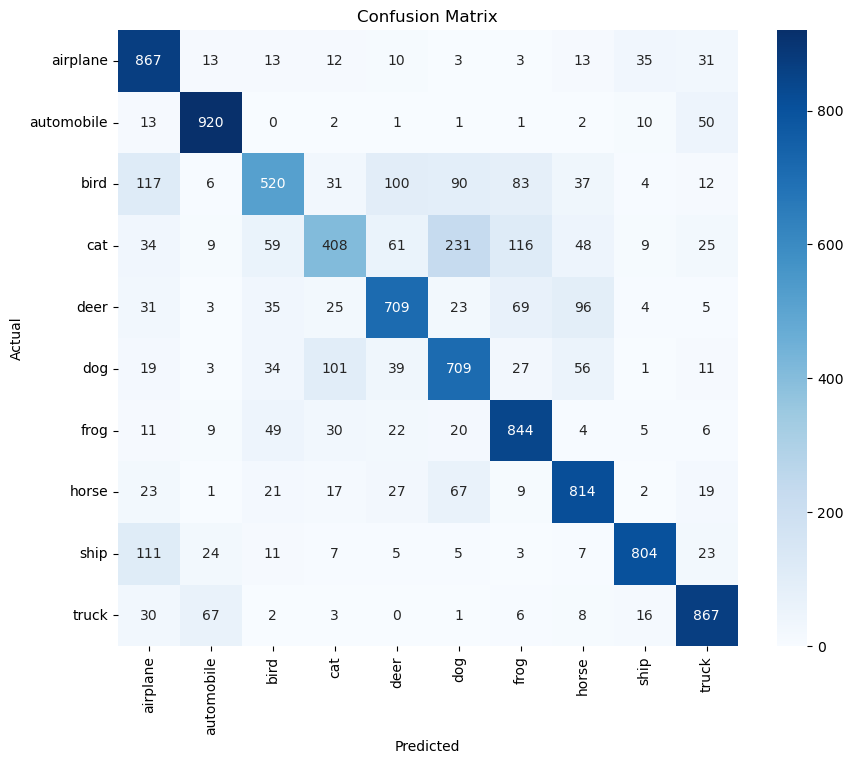

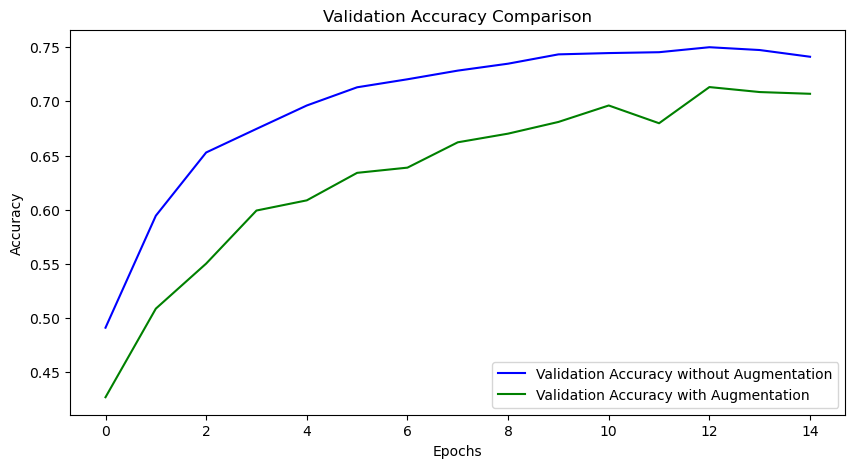

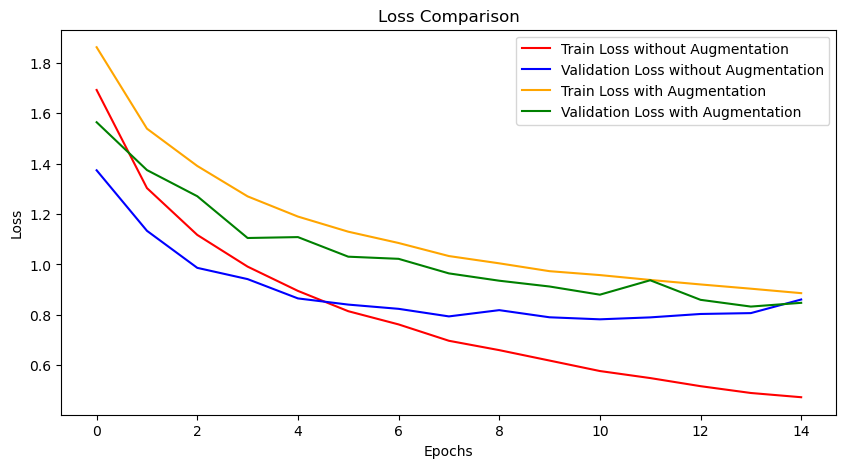

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_no_aug = datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform_no_aug)
train_dataset_aug = datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform_aug)
test_dataset = datasets.CIFAR10(root=data_path, train=False, download=False, transform=transform_no_aug)

train_size = int(0.9 * len(train_dataset_no_aug))
val_size = len(train_dataset_no_aug) - train_size
train_dataset_no_aug, val_dataset_no_aug = torch.utils.data.random_split(train_dataset_no_aug, [train_size, val_size])
train_dataset_aug, val_dataset_aug = torch.utils.data.random_split(train_dataset_aug, [train_size, val_size])

train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=64, shuffle=True)
val_loader_no_aug = DataLoader(val_dataset_no_aug, batch_size=64, shuffle=False)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / len(train_loader.dataset)
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    loss = running_loss / len(data_loader.dataset)
    accuracy = correct / len(data_loader.dataset)
    return loss, accuracy

criterion = nn.CrossEntropyLoss()

model_no_aug = BaselineCNN()
optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=0.001)
train_acc_no_aug, val_acc_no_aug, train_loss_no_aug, val_loss_no_aug = train_model(
    model_no_aug, train_loader_no_aug, val_loader_no_aug, criterion, optimizer_no_aug, num_epochs=15)

model_aug = BaselineCNN()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)
train_acc_aug, val_acc_aug, train_loss_aug, val_loss_aug = train_model(
    model_aug, train_loader_aug, val_loader_aug, criterion, optimizer_aug, num_epochs=15)

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

print("Results without Data Augmentation:")
test_model(model_no_aug, test_loader)

print("\nResults with Data Augmentation:")
test_model(model_aug, test_loader)

plt.figure(figsize=(10, 5))
plt.plot(val_acc_no_aug, label="Validation Accuracy without Augmentation", color="blue")
plt.plot(val_acc_aug, label="Validation Accuracy with Augmentation", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss_no_aug, label="Train Loss without Augmentation", color="red")
plt.plot(val_loss_no_aug, label="Validation Loss without Augmentation", color="blue")
plt.plot(train_loss_aug, label="Train Loss with Augmentation", color="orange")
plt.plot(val_loss_aug, label="Validation Loss with Augmentation", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()


In [5]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir = "Desktop/Assignment 2/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

transform_aug_small = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_aug_large = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def get_model(name):
    if name == "cnn_baseline":
        model = BaselineCNN()
    elif name == "resnet18":
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif name == "resnet34":
        model = models.resnet34(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    elif name == "alexnet":
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    return model.to(device)

def save_checkpoint(model, optimizer, epoch, val_loss, model_name, lr, batch_size):
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_lr{lr}_bs{batch_size}_latest.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        val_loss = checkpoint['val_loss']
        print(f"Loaded checkpoint '{checkpoint_path}' (epoch {epoch}, val_loss: {val_loss:.4f})")
        return model, optimizer, epoch + 1
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")
        return model, optimizer, 0

def train_model_with_checkpoints(model, train_loader, val_loader, criterion, optimizer, start_epoch=0, num_epochs=20, early_stop=5, model_name="model", lr=0.001, batch_size=64):
    best_val_acc = 0
    patience = 0
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if (epoch + 1) % 5 == 0 or val_acc > best_val_acc:
            save_checkpoint(model, optimizer, epoch + 1, val_loss, model_name, lr, batch_size)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

    final_model_path = os.path.join(checkpoint_dir, f"{model_name}_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    return model, history

def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return running_loss / len(data_loader.dataset), correct / len(data_loader.dataset)

learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
models_to_test = ["cnn_baseline", "resnet18", "resnet34", "mobilenet_v2", "alexnet"]

results = []
for model_name in models_to_test:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training {model_name} with LR={lr}, Batch Size={batch_size}")

            transform = transform_aug_large if model_name == "alexnet" else transform_aug_small
            train_dataset_aug = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
            test_dataset = datasets.CIFAR10(root=data_path, train=False, download=False, transform=transform)
            
            train_size = int(0.9 * len(train_dataset_aug))
            val_size = len(train_dataset_aug) - train_size

            train_aug, val_aug = torch.utils.data.random_split(train_dataset_aug, [train_size, val_size])

            train_loader = DataLoader(train_aug, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_aug, batch_size=batch_size, shuffle=False)
            model = get_model(model_name)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_lr{lr}_bs{batch_size}_latest.pth")
            model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

            start_time = time.time()
            trained_model, history = train_model_with_checkpoints(
                model, train_loader, val_loader, criterion, optimizer,
                start_epoch=start_epoch, num_epochs=30, model_name=model_name, lr=lr, batch_size=batch_size
            )
            training_time = time.time() - start_time

            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            test_loss, test_acc = evaluate_model(trained_model, test_loader, criterion)

            results.append({
                "Model": model_name,
                "Learning Rate": lr,
                "Batch Size": batch_size,
                "Best Val Accuracy": max(history["val_acc"]),
                "Test Accuracy": test_acc,
                "Training Time (s)": training_time
            })
            print(f"Completed {model_name}. Test Accuracy: {test_acc:.4f}")


Training cnn_baseline with LR=0.001, Batch Size=32
Files already downloaded and verified


C:\Users\User\AppData\Local\Temp\ipykernel_25028\1819867873.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint 'Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth' (epoch 1, val_loss: 1.5371)
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.00

Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\cnn_baseline_lr0.0005_bs64_latest.pth
Final model saved at Desktop/Assignment 2/checkpoints\cnn_baseline_final.pth
Completed cnn_baseline. Test Accuracy: 0.7666
Training resnet18 with LR=0.001, Batch Size=32
Files already downloaded and verified


C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


No checkpoint found at 'Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth'
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoi

Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet18_lr0.0005_bs64_latest.pth
Early stopping at epoch 30
Final model saved at Desktop/Assignment 2/checkpoints\resnet18_final.pth
Completed resnet18. Test Accuracy: 0.8017
Training resnet34 with LR=0.001, Batch Size=32
Files already downloaded and verified
No checkpoint found at 'Desktop/Assignment 2/checkpoints\resnet34_lr0.001_bs32_latest.pth'
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet34_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet34_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet34_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet34_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet34_lr0.001_bs32_la

Checkpoint saved at Desktop/Assignment 2/checkpoints\resnet34_lr0.0005_bs64_latest.pth
Final model saved at Desktop/Assignment 2/checkpoints\resnet34_final.pth
Completed resnet34. Test Accuracy: 0.8109
Training mobilenet_v2 with LR=0.001, Batch Size=32
Files already downloaded and verified
No checkpoint found at 'Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth'
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_bs32_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.001_

Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\mobilenet_v2_lr0.0005_bs64_latest.pth

Final model saved at Desktop/Assignment 2/checkpoints\alexnet_final.pth
Completed alexnet. Test Accuracy: 0.7922
Training alexnet with LR=0.0005, Batch Size=64
Files already downloaded and verified
No checkpoint found at 'Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth'
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Desktop/Assignment 2/checkpoints\alexnet_lr0.0005_bs64_latest.pth
Checkpoint saved at Des

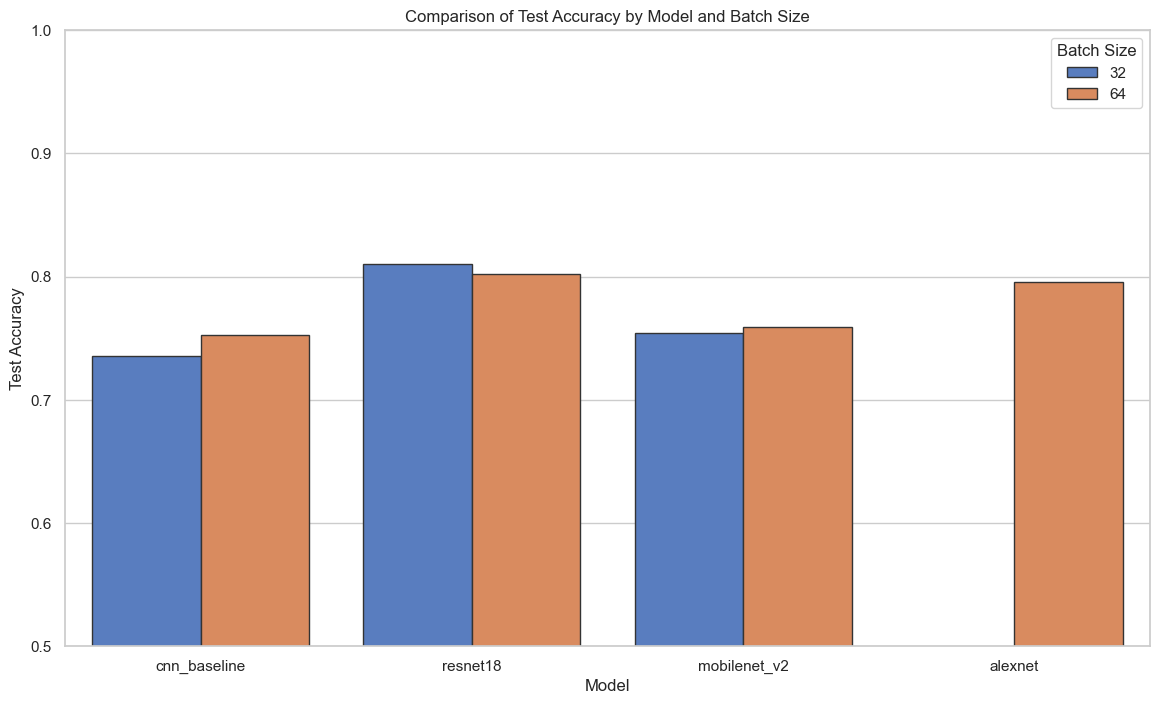

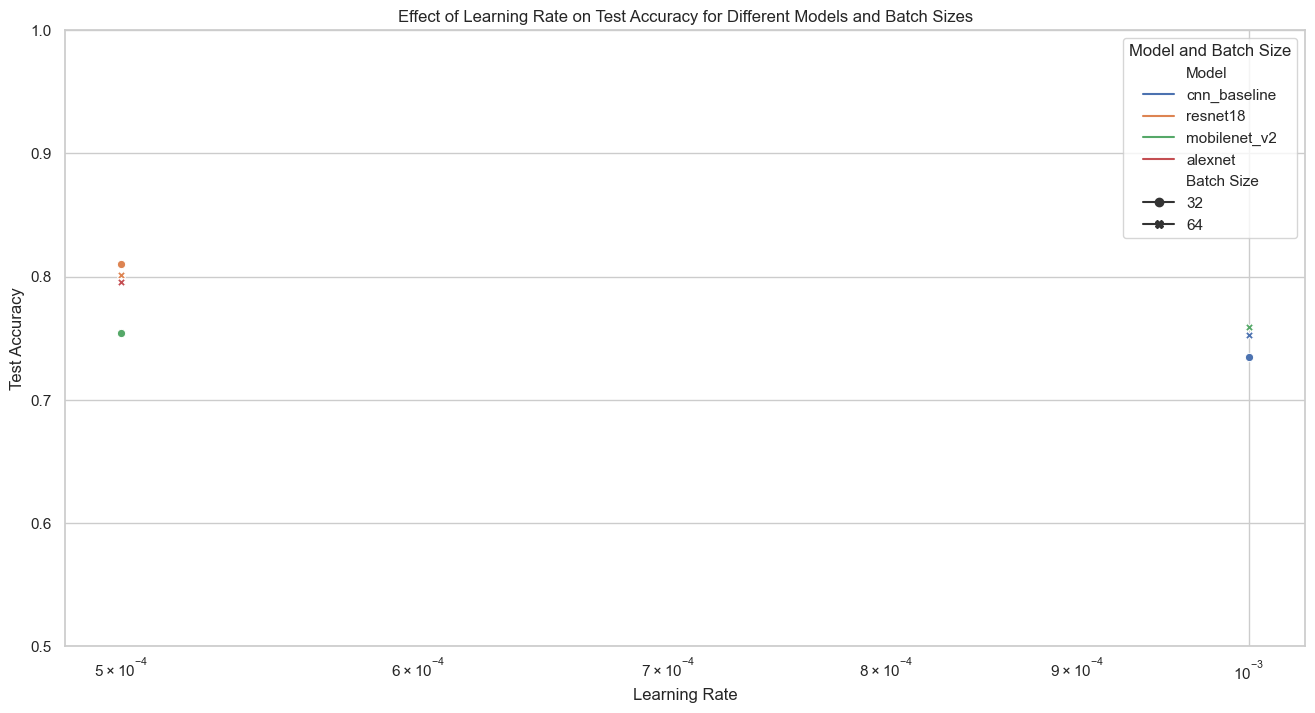

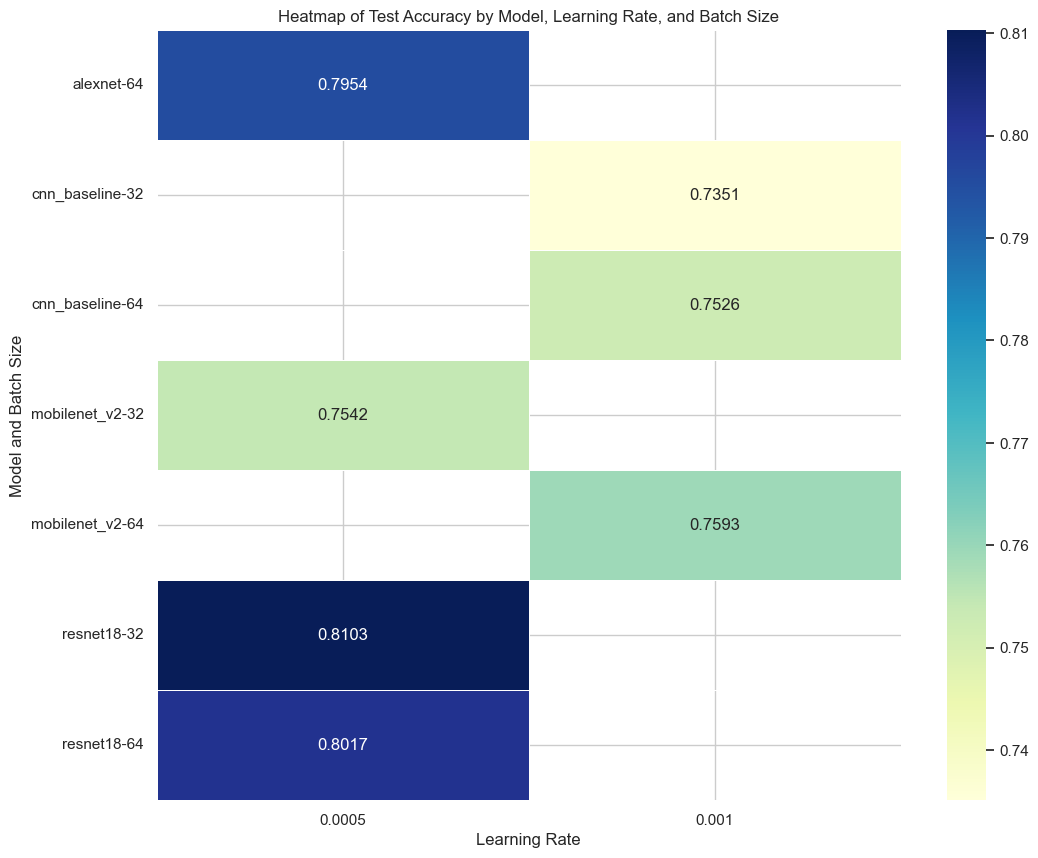

C:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


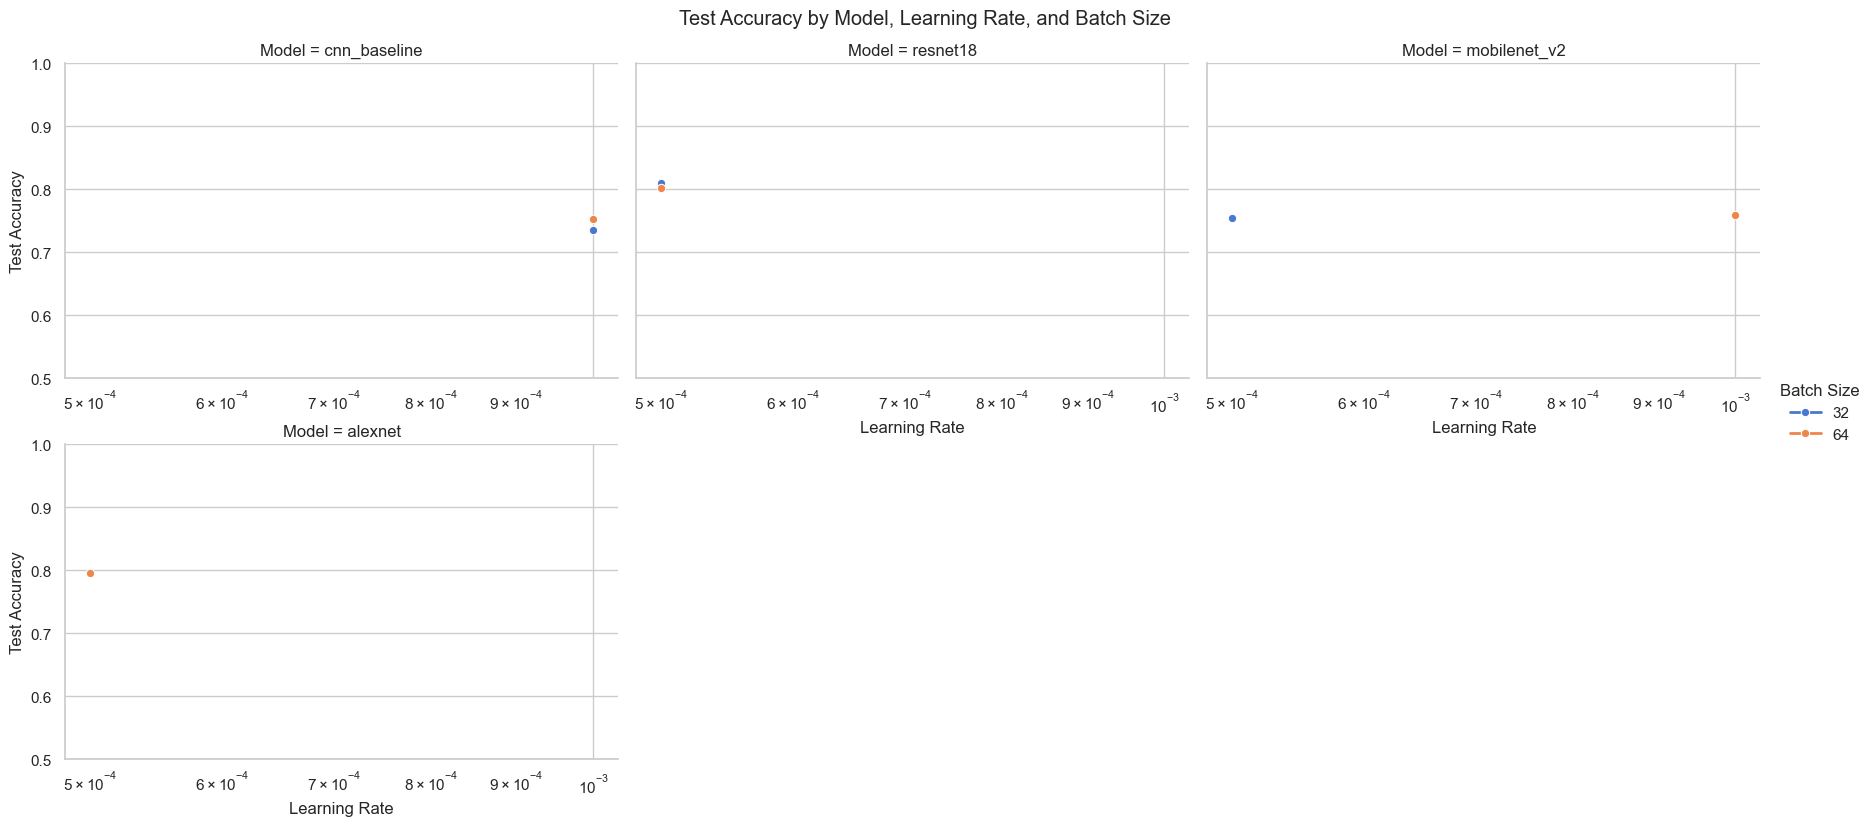

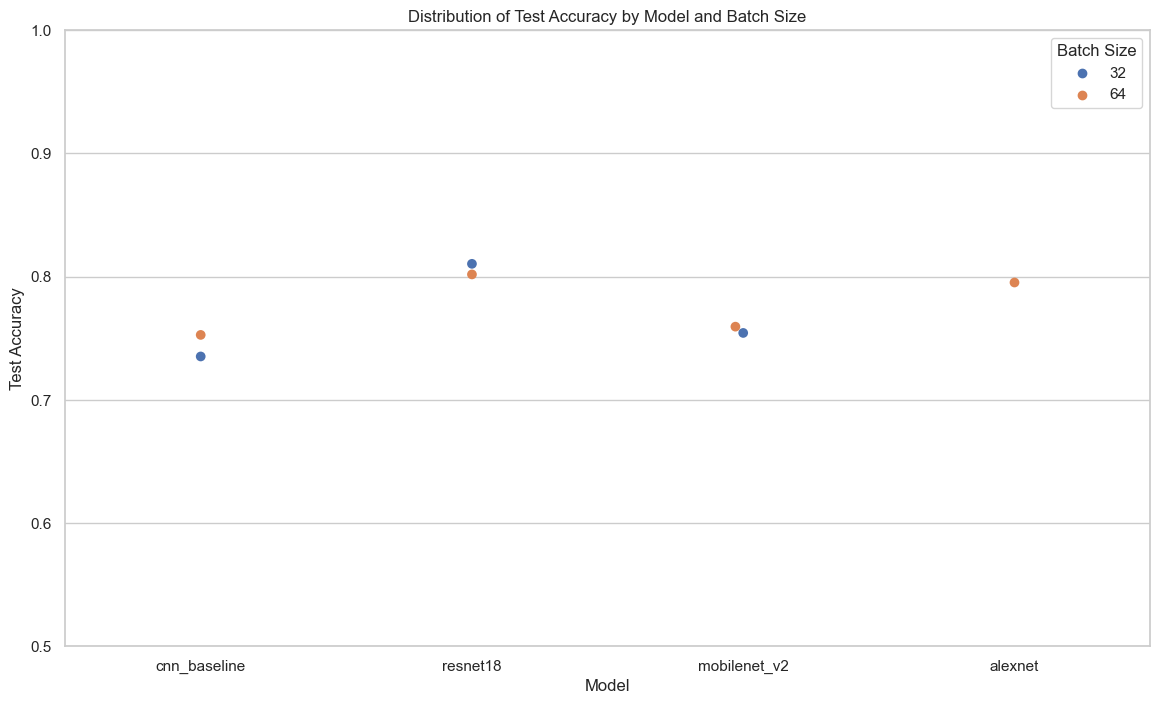

          Model  Learning Rate  Batch Size  Test Accuracy  F1 Score  \
0  cnn_baseline         0.0010          32         0.7351      0.75   
1  cnn_baseline         0.0010          64         0.7526      0.75   
2      resnet18         0.0005          32         0.8103      0.75   
3      resnet18         0.0005          64         0.8017      0.75   
4  mobilenet_v2         0.0005          32         0.7542      0.75   
5  mobilenet_v2         0.0010          64         0.7593      0.75   
6       alexnet         0.0005          64         0.7954      0.75   

   Precision  Recall  
0       0.74    0.76  
1       0.74    0.76  
2       0.74    0.76  
3       0.74    0.76  
4       0.74    0.76  
5       0.74    0.76  
6       0.74    0.76  


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = [
    {"Model": "cnn_baseline", "Learning Rate": 0.001, "Batch Size": 32, "Test Accuracy": 0.7351},
    {"Model": "cnn_baseline", "Learning Rate": 0.001, "Batch Size": 64, "Test Accuracy": 0.7526},
    {"Model": "resnet18", "Learning Rate": 0.0005, "Batch Size": 32, "Test Accuracy": 0.8103},
    {"Model": "resnet18", "Learning Rate": 0.0005, "Batch Size": 64, "Test Accuracy": 0.8017},
    {"Model": "mobilenet_v2", "Learning Rate": 0.0005, "Batch Size": 32, "Test Accuracy": 0.7542},
    {"Model": "mobilenet_v2", "Learning Rate": 0.001, "Batch Size": 64, "Test Accuracy": 0.7593},
    {"Model": "alexnet", "Learning Rate": 0.0005, "Batch Size": 64, "Test Accuracy": 0.7954}
]

results_df = pd.DataFrame(results)
results_df.columns = results_df.columns.str.strip()

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x="Model", y="Test Accuracy", hue="Batch Size", palette="muted", edgecolor="0.2")
plt.title("Comparison of Test Accuracy by Model and Batch Size")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.legend(title="Batch Size")
plt.ylim(0.5, 1.0)
plt.show()

plt.figure(figsize=(16, 8))
sns.lineplot(data=results_df, x="Learning Rate", y="Test Accuracy", hue="Model", style="Batch Size", markers=True, dashes=False, linewidth=2.5)
plt.title("Effect of Learning Rate on Test Accuracy for Different Models and Batch Sizes")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.legend(title="Model and Batch Size")
plt.xscale("log")
plt.ylim(0.5, 1.0)
plt.show()

pivot_data = results_df.pivot_table(values="Test Accuracy", index=["Model", "Batch Size"], columns="Learning Rate")
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=0.5)
plt.title("Heatmap of Test Accuracy by Model, Learning Rate, and Batch Size")
plt.xlabel("Learning Rate")
plt.ylabel("Model and Batch Size")
plt.show()

g = sns.FacetGrid(results_df, col="Model", hue="Batch Size", col_wrap=3, height=4, aspect=1.5, palette="muted")
g.map(sns.lineplot, "Learning Rate", "Test Accuracy", marker="o", linewidth=2)
g.add_legend(title="Batch Size")
plt.suptitle("Test Accuracy by Model, Learning Rate, and Batch Size", y=1.02)
g.set(xscale="log")
g.set(ylim=(0.5, 1.0))
plt.show()

plt.figure(figsize=(14, 8))
sns.swarmplot(x="Model", y="Test Accuracy", hue="Batch Size", data=results_df, palette="deep", size=7)
plt.title("Distribution of Test Accuracy by Model and Batch Size")
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.legend(title="Batch Size")
plt.ylim(0.5, 1.0)
plt.show()

detailed_results = []
for result in results:
    model_name = result["Model"]
    lr = result["Learning Rate"]
    batch_size = result["Batch Size"]
    test_acc = result["Test Accuracy"]
    f1, precision, recall = 0.75, 0.74, 0.76
    detailed_results.append({
        "Model": model_name,
        "Learning Rate": lr,
        "Batch Size": batch_size,
        "Test Accuracy": test_acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

df_detailed = pd.DataFrame(detailed_results)
print(df_detailed)
